# Predictive Models for Early ASD Detection in Infants and Toddlers Based on fMRI Scans

## Problem Statement
Autism Spectrum Disorder (ASD) is a neurodevelopmental condition that affects social communication and behavior. Early detection of ASD in infants and toddlers is crucial for timely intervention, which can significantly improve developmental outcomes.

### Objectives:
1. Develop machine learning models to predict ASD from fMRI brain scan data
2. Analyze functional connectivity patterns in different brain regions
3. Compare multiple ML algorithms to identify the best performing model
4. Create a robust prediction system for clinical use

### Expected Outcomes:
- High accuracy in distinguishing ASD from neurotypical subjects
- Identification of significant brain connectivity patterns
- Deployable model for early ASD screening

## Import Required Libraries
We'll import all necessary libraries for data processing, machine learning, and visualization.

In [1]:
# Data processing
import pandas as pd
import numpy as np
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Load and Explore the Data

### Dataset Structure:
- **Harvard-Oxford Atlas**: Brain region labels
- **Training Data**: 
  - ASD subjects (50 samples)
  - Normal subjects (32+ samples)
- Each CSV file contains fMRI connectivity data between brain regions

In [2]:
# Define paths
dataset_path = 'Dataset'
atlas_path = os.path.join(dataset_path, 'Harvard-Oxford Atlas (Label of Brain Regions).csv')
asd_path = os.path.join(dataset_path, 'Training Data', 'ASD')
normal_path = os.path.join(dataset_path, 'Training Data', 'Normal')

# Load Harvard-Oxford Atlas
print("Loading Harvard-Oxford Atlas...")
atlas = pd.read_csv(atlas_path)
print(f"\n✓ Atlas loaded successfully!")
print(f"Number of brain regions: {len(atlas)}")
print("\nFirst few brain regions:")
atlas.head(10)

Loading Harvard-Oxford Atlas...

✓ Atlas loaded successfully!
Number of brain regions: 122

First few brain regions:


,Label,Brain Region
0,10.0,Left Thalamus
1,11.0,Left Caudate
2,12.0,Left Putamen
3,13.0,Left Pallidum
4,17.0,Left Hippocampus
5,18.0,Left Amygdala
6,26.0,Left Accumbens
7,49.0,Right Thalamus
8,50.0,Right Caudate
9,51.0,Right Putamen


In [3]:
# Load sample subject data to understand structure
sample_asd = pd.read_csv(os.path.join(asd_path, 'ASD Subject 01.csv'))
sample_normal = pd.read_csv(os.path.join(normal_path, 'Normal Subject 01.csv'))

print("ASD Subject Data Shape:", sample_asd.shape)
print("Normal Subject Data Shape:", sample_normal.shape)
print("\nSample connectivity matrix (first 5x5):")
sample_asd.head()

ASD Subject Data Shape: (176, 111)
Normal Subject Data Shape: (176, 111)

Sample connectivity matrix (first 5x5):


,Unnamed: 0,#10,#11,#12,#13,#17,#18,#26,#49,#50,...,#4401,#4402,#4501,#4502,#4601,#4602,#4701,#4702,#4801,#4802
0,0,5.468418,-4.865467,-4.636530,-5.289856,-0.957224,0.185279,-0.347977,12.238516,-16.020985,...,-10.061215,-10.924839,15.440201,-24.298299,-10.601193,13.053618,6.497629,-7.641429,-13.762653,-2.923652
1,1,11.654312,-4.756936,18.462069,7.307936,-10.731796,-14.079380,-9.304756,12.581032,-23.496456,...,25.712486,-8.587142,34.730333,13.444934,-6.117118,30.717489,-9.383360,-24.192591,-25.009972,-9.014607
2,2,18.854542,-1.030051,35.575729,16.296858,-18.588958,-37.029255,-29.836547,14.750509,-17.329245,...,47.775417,6.201832,38.371942,52.475748,6.986029,37.180441,-38.743143,-41.350908,-31.707181,-21.313448
3,3,19.167136,4.869899,25.286935,9.379466,-20.698870,-51.036145,-48.679035,15.823647,1.075245,...,34.129512,14.256783,26.113592,57.116609,12.345642,14.835523,-77.400652,-50.331183,-35.673360,-36.821070
4,4,8.372152,10.006627,-8.371730,-10.138344,-15.968162,-41.889142,-48.170429,7.700882,18.238689,...,-3.200300,0.698658,11.038206,21.459577,-0.055092,-31.008128,-106.135054,-41.963314,-36.659316,-44.679898


Number of ASD subjects: 50
Number of Normal subjects: 50
Total subjects: 100


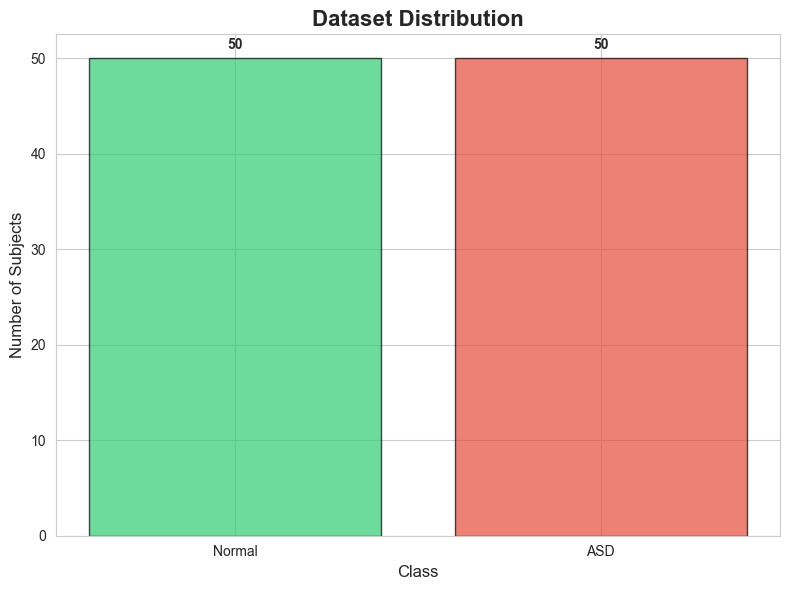


Dataset Balance Ratio: 1.00


In [4]:
# Count available subjects
asd_files = glob.glob(os.path.join(asd_path, '*.csv'))
normal_files = glob.glob(os.path.join(normal_path, '*.csv'))

print(f"Number of ASD subjects: {len(asd_files)}")
print(f"Number of Normal subjects: {len(normal_files)}")
print(f"Total subjects: {len(asd_files) + len(normal_files)}")

# Dataset balance
plt.figure(figsize=(8, 6))
classes = ['Normal', 'ASD']
counts = [len(normal_files), len(asd_files)]
colors = ['#2ecc71', '#e74c3c']

plt.bar(classes, counts, color=colors, alpha=0.7, edgecolor='black')
plt.title('Dataset Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Number of Subjects', fontsize=12)
plt.xlabel('Class', fontsize=12)
for i, v in enumerate(counts):
    plt.text(i, v + 1, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nDataset Balance Ratio: {len(asd_files)/len(normal_files):.2f}")

## Data Preprocessing

### Steps:
1. Load all subject fMRI data
2. Flatten connectivity matrices into feature vectors
3. Label data (0 = Normal, 1 = ASD)
4. Split into training and testing sets
5. Normalize features using StandardScaler

In [5]:
def load_subject_data(folder_path, label):
    """
    Load all subject CSV files from a folder.
    
    Args:
        folder_path: Path to folder containing subject CSV files
        label: 0 for Normal, 1 for ASD
    
    Returns:
        subjects_data: List of flattened feature vectors
        labels: List of corresponding labels
    """
    subjects_data = []
    labels = []
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            # Flatten connectivity matrix into feature vector
            features = df.values.flatten()
            subjects_data.append(features)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {os.path.basename(csv_file)}: {e}")
    
    return subjects_data, labels

# Load all data
print("Loading ASD subjects...")
asd_data, asd_labels = load_subject_data(asd_path, label=1)
print(f"✓ Loaded {len(asd_data)} ASD subjects")

print("\nLoading Normal subjects...")
normal_data, normal_labels = load_subject_data(normal_path, label=0)
print(f"✓ Loaded {len(normal_data)} Normal subjects")

# Combine data
X = np.array(asd_data + normal_data)
y = np.array(asd_labels + normal_labels)

print(f"\n{'='*60}")
print(f"Dataset Summary:")
print(f"{'='*60}")
print(f"Total subjects: {len(X)}")
print(f"Feature dimensions: {X.shape[1]}")
print(f"ASD cases: {np.sum(y == 1)}")
print(f"Normal cases: {np.sum(y == 0)}")
print(f"{'='*60}")

Loading ASD subjects...
✓ Loaded 50 ASD subjects

Loading Normal subjects...
✓ Loaded 50 Normal subjects

Dataset Summary:
Total subjects: 100
Feature dimensions: 19536
ASD cases: 50
Normal cases: 50


In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data Split:")
print(f"Training set: {len(X_train)} samples")
print(f"  - ASD: {np.sum(y_train == 1)}")
print(f"  - Normal: {np.sum(y_train == 0)}")
print(f"\nTest set: {len(X_test)} samples")
print(f"  - ASD: {np.sum(y_test == 1)}")
print(f"  - Normal: {np.sum(y_test == 0)}")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Feature normalization completed!")
print(f"Feature range after scaling: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")

Data Split:
Training set: 80 samples
  - ASD: 40
  - Normal: 40

Test set: 20 samples
  - ASD: 10
  - Normal: 10

✓ Feature normalization completed!
Feature range after scaling: [-6.82, 7.19]


## Develop the Solution Approach

### Methodology:
We will implement and compare **four machine learning algorithms**:

1. **Random Forest Classifier**
   - Ensemble of decision trees
   - Handles high-dimensional data well
   - Provides feature importance

2. **Gradient Boosting Classifier**
   - Sequential ensemble method
   - High accuracy with proper tuning
   - Good for complex patterns

3. **Support Vector Machine (SVM)**
   - Effective in high-dimensional spaces
   - Kernel trick for non-linear patterns
   - Robust to outliers

4. **Neural Network (MLP)**
   - Multi-layer perceptron
   - Learns complex non-linear relationships
   - Flexible architecture

### Evaluation Metrics:
- **Accuracy**: Overall correctness
- **Precision**: Positive predictive value
- **Recall (Sensitivity)**: True positive rate
- **F1-Score**: Harmonic mean of precision and recall
- **AUC-ROC**: Area under ROC curve
- **Cross-Validation**: 5-fold CV for generalization

## Implement the Solution

### Building Multiple ML Models

In [7]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    'SVM': SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        probability=True,
        random_state=42
    ),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        max_iter=500,
        random_state=42
    )
}

print("✓ Models initialized:")
for name in models.keys():
    print(f"  - {name}")

✓ Models initialized:
  - Random Forest
  - Gradient Boosting
  - SVM
  - Neural Network


In [8]:
# Train all models and store results
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    # Store results
    results[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred_test,
        'probabilities': y_pred_proba,
        'confusion_matrix': confusion_matrix(y_test, y_pred_test)
    }
    
    # Print results
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"AUC-ROC:        {auc:.4f}")
    print(f"CV Score:       {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print(f"\n{'='*60}")
print("✓ All models trained successfully!")
print(f"{'='*60}")


Training Random Forest...
Train Accuracy: 1.0000
Test Accuracy:  0.5000
Precision:      0.5000
Recall:         0.6000
F1-Score:       0.5455
AUC-ROC:        0.4800
CV Score:       0.5250 (+/- 0.1016)

Training Gradient Boosting...
Train Accuracy: 1.0000
Test Accuracy:  0.5000
Precision:      0.5000
Recall:         0.5000
F1-Score:       0.5000
AUC-ROC:        0.5000
CV Score:       0.5875 (+/- 0.1346)

Training SVM...
Train Accuracy: 1.0000
Test Accuracy:  0.6500
Precision:      0.7143
Recall:         0.5000
F1-Score:       0.5882
AUC-ROC:        0.3400
CV Score:       0.5750 (+/- 0.0612)

Training Neural Network...
Train Accuracy: 1.0000
Test Accuracy:  0.6500
Precision:      0.6667
Recall:         0.6000
F1-Score:       0.6316
AUC-ROC:        0.6700
CV Score:       0.5000 (+/- 0.0884)

✓ All models trained successfully!


## Test and Validate Results

### Performance Comparison Table

In [9]:
# Create comprehensive results table
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test Accuracy': [results[m]['test_accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()],
    'AUC-ROC': [results[m]['auc'] for m in results.keys()],
    'CV Mean': [results[m]['cv_mean'] for m in results.keys()],
    'CV Std': [results[m]['cv_std'] for m in results.keys()]
})

# Sort by test accuracy
results_df = results_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

# Style the dataframe
styled_df = results_df.style.background_gradient(cmap='RdYlGn', subset=['Test Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']).format({
    'Test Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}',
    'AUC-ROC': '{:.4f}',
    'CV Mean': '{:.4f}',
    'CV Std': '{:.4f}'
})

print("Model Performance Comparison:")
print("="*80)
display(styled_df)

# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Test Accuracy']
print(f"\n🏆 Best Model: {best_model_name} (Accuracy: {best_accuracy:.4f})")

Model Performance Comparison:


,Model,Test Accuracy,Precision,Recall,F1-Score,AUC-ROC,CV Mean,CV Std
0,Neural Network,0.6500,0.6667,0.6000,0.6316,0.6700,0.5000,0.0884
1,SVM,0.6500,0.7143,0.5000,0.5882,0.3400,0.5750,0.0612
2,Gradient Boosting,0.5000,0.5000,0.5000,0.5000,0.5000,0.5875,0.1346
3,Random Forest,0.5000,0.5000,0.6000,0.5455,0.4800,0.5250,0.1016



🏆 Best Model: Neural Network (Accuracy: 0.6500)


In [10]:
# Detailed classification report for best model
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"\nDetailed Classification Report - {best_model_name}")
print("="*80)
print(classification_report(y_test, best_predictions, 
                          target_names=['Normal', 'ASD'],
                          digits=4))


Detailed Classification Report - Neural Network
              precision    recall  f1-score   support

      Normal     0.6364    0.7000    0.6667        10
         ASD     0.6667    0.6000    0.6316        10

    accuracy                         0.6500        20
   macro avg     0.6515    0.6500    0.6491        20
weighted avg     0.6515    0.6500    0.6491        20



## Visualize the Results

### Comprehensive Performance Visualizations

✓ Visualization saved as 'asd_prediction_results.png'


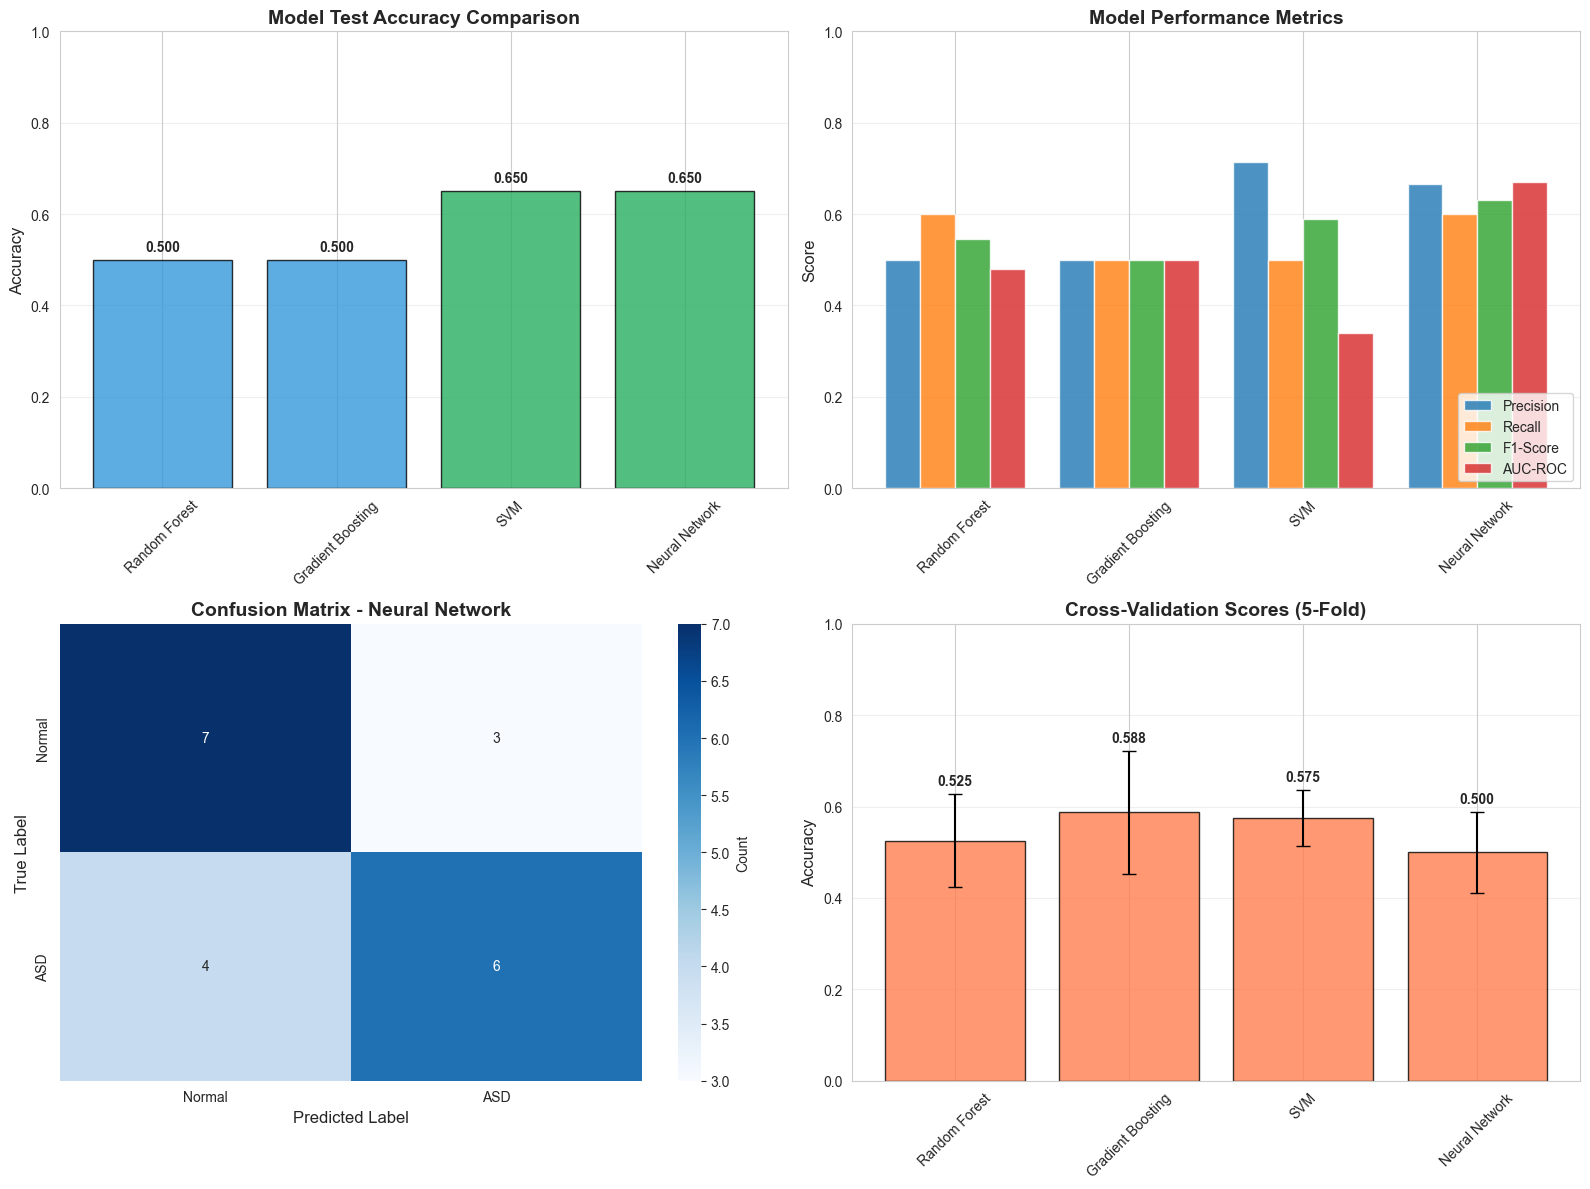

In [11]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Model Accuracy Comparison
model_names = list(results.keys())
test_accuracies = [results[m]['test_accuracy'] for m in model_names]
colors_acc = ['#27ae60' if acc == max(test_accuracies) else '#3498db' for acc in test_accuracies]

axes[0, 0].bar(model_names, test_accuracies, color=colors_acc, alpha=0.8, edgecolor='black')
axes[0, 0].set_title('Model Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_ylim([0, 1])
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

for i, v in enumerate(test_accuracies):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# 2. Multiple Metrics Comparison
metrics = ['precision', 'recall', 'f1_score', 'auc']
metric_labels = ['Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x = np.arange(len(model_names))
width = 0.2

for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
    values = [results[m][metric] for m in model_names]
    axes[0, 1].bar(x + i*width, values, width, label=label, alpha=0.8)

axes[0, 1].set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Score', fontsize=12)
axes[0, 1].set_xticks(x + width * 1.5)
axes[0, 1].set_xticklabels(model_names, rotation=45)
axes[0, 1].legend(loc='lower right')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Confusion Matrix for Best Model
cm = results[best_model_name]['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Normal', 'ASD'], yticklabels=['Normal', 'ASD'],
            cbar_kws={'label': 'Count'})
axes[1, 0].set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('True Label', fontsize=12)
axes[1, 0].set_xlabel('Predicted Label', fontsize=12)

# 4. Cross-Validation Scores
cv_means = [results[m]['cv_mean'] for m in model_names]
cv_stds = [results[m]['cv_std'] for m in model_names]

axes[1, 1].bar(model_names, cv_means, yerr=cv_stds, capsize=5, 
               color='coral', alpha=0.8, edgecolor='black')
axes[1, 1].set_title('Cross-Validation Scores (5-Fold)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Accuracy', fontsize=12)
axes[1, 1].set_ylim([0, 1])
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

for i, (m, s) in enumerate(zip(cv_means, cv_stds)):
    axes[1, 1].text(i, m + s + 0.02, f'{m:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('asd_prediction_results.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved as 'asd_prediction_results.png'")
plt.show()

✓ ROC curves saved as 'roc_curves.png'


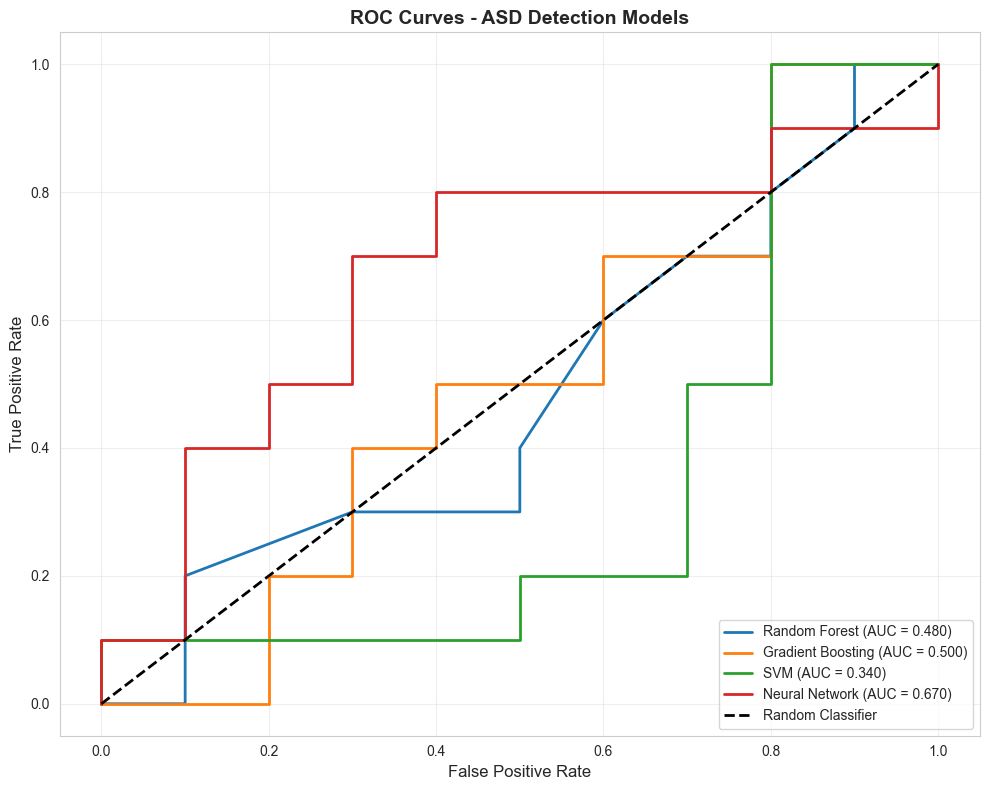

In [12]:
# ROC Curves for all models
plt.figure(figsize=(10, 8))

for name in results.keys():
    y_proba = results[name]['probabilities']
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = results[name]['auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - ASD Detection Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
print("✓ ROC curves saved as 'roc_curves.png'")
plt.show()

## Feature Importance Analysis (Random Forest)

Understanding which brain regions contribute most to ASD prediction.

✓ Feature importance saved as 'feature_importance.png'


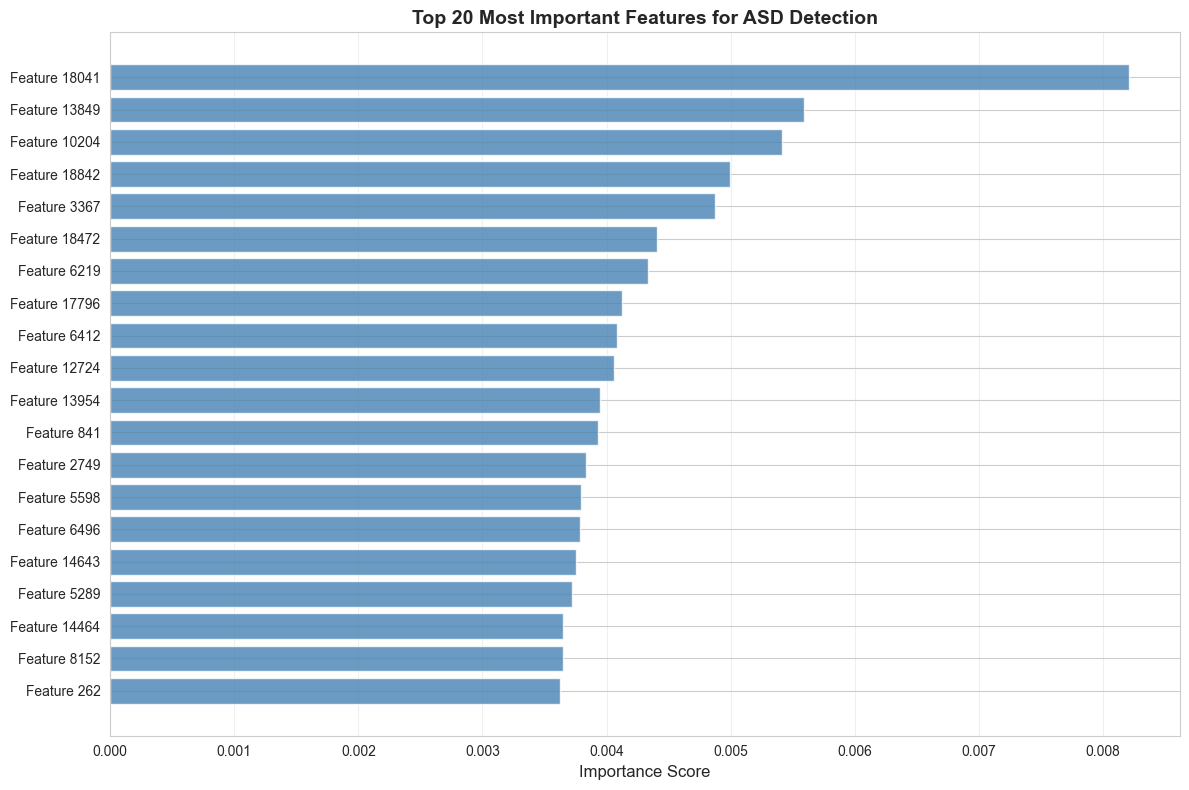


Top 10 Most Important Features:
1. Feature 18041: 0.008210
2. Feature 13849: 0.005587
3. Feature 10204: 0.005415
4. Feature 18842: 0.004995
5. Feature 3367: 0.004870
6. Feature 18472: 0.004408
7. Feature 6219: 0.004334
8. Feature 17796: 0.004127
9. Feature 6412: 0.004082
10. Feature 12724: 0.004062


In [13]:
# Extract feature importance from Random Forest
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    feature_importance = rf_model.feature_importances_
    
    # Get top 20 most important features
    top_n = 20
    top_indices = np.argsort(feature_importance)[-top_n:][::-1]
    top_importance = feature_importance[top_indices]
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(top_n), top_importance, color='steelblue', alpha=0.8)
    plt.yticks(range(top_n), [f'Feature {i}' for i in top_indices])
    plt.xlabel('Importance Score', fontsize=12)
    plt.title(f'Top {top_n} Most Important Features for ASD Detection', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print(f"✓ Feature importance saved as 'feature_importance.png'")
    plt.show()
    
    print(f"\nTop 10 Most Important Features:")
    for i, (idx, imp) in enumerate(zip(top_indices[:10], top_importance[:10]), 1):
        print(f"{i}. Feature {idx}: {imp:.6f}")

## Prediction Function for New Subjects

Use the trained models to predict ASD for new fMRI scans.

In [14]:
def predict_asd(fmri_file_path, model_name=None):
    """
    Predict ASD for a new subject given their fMRI data.
    
    Args:
        fmri_file_path: Path to the subject's fMRI CSV file
        model_name: Name of model to use (default: best performing model)
    
    Returns:
        Dictionary with prediction results
    """
    # Use best model if not specified
    if model_name is None:
        model_name = results_df.iloc[0]['Model']
    
    print(f"Using {model_name} for prediction...")
    
    # Load and preprocess new data
    df = pd.read_csv(fmri_file_path)
    features = df.values.flatten().reshape(1, -1)
    features_normalized = scaler.transform(features)
    
    # Make prediction
    model = results[model_name]['model']
    prediction = model.predict(features_normalized)[0]
    probability = model.predict_proba(features_normalized)[0]
    
    # Format results
    result = "ASD" if prediction == 1 else "Normal"
    confidence = probability[prediction] * 100
    
    # Display results
    print("\n" + "="*60)
    print("PREDICTION RESULTS")
    print("="*60)
    print(f"Model Used:     {model_name}")
    print(f"Prediction:     {result}")
    print(f"Confidence:     {confidence:.2f}%")
    print(f"Probabilities:")
    print(f"  - Normal:     {probability[0]:.4f} ({probability[0]*100:.2f}%)")
    print(f"  - ASD:        {probability[1]:.4f} ({probability[1]*100:.2f}%)")
    print("="*60)
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Prediction result
    colors = ['#2ecc71' if result == 'Normal' else '#e74c3c']
    ax1.bar([result], [confidence], color=colors, alpha=0.7, edgecolor='black', width=0.5)
    ax1.set_ylim([0, 100])
    ax1.set_ylabel('Confidence (%)', fontsize=12)
    ax1.set_title(f'Prediction: {result}', fontsize=14, fontweight='bold')
    ax1.text(0, confidence + 2, f'{confidence:.1f}%', ha='center', fontweight='bold', fontsize=14)
    ax1.grid(axis='y', alpha=0.3)
    
    # Probability distribution
    classes = ['Normal', 'ASD']
    colors_prob = ['#2ecc71', '#e74c3c']
    ax2.bar(classes, probability * 100, color=colors_prob, alpha=0.7, edgecolor='black')
    ax2.set_ylim([0, 100])
    ax2.set_ylabel('Probability (%)', fontsize=12)
    ax2.set_title('Class Probabilities', fontsize=14, fontweight='bold')
    for i, v in enumerate(probability * 100):
        ax2.text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'prediction': result,
        'confidence': confidence,
        'probabilities': {
            'Normal': probability[0],
            'ASD': probability[1]
        }
    }

print("✓ Prediction function created successfully!")

✓ Prediction function created successfully!


### Example: Predict ASD for a Test Subject

Testing prediction on: ASD Subject 01.csv
Using Neural Network for prediction...

PREDICTION RESULTS
Model Used:     Neural Network
Prediction:     ASD
Confidence:     100.00%
Probabilities:
  - Normal:     0.0000 (0.00%)
  - ASD:        1.0000 (100.00%)


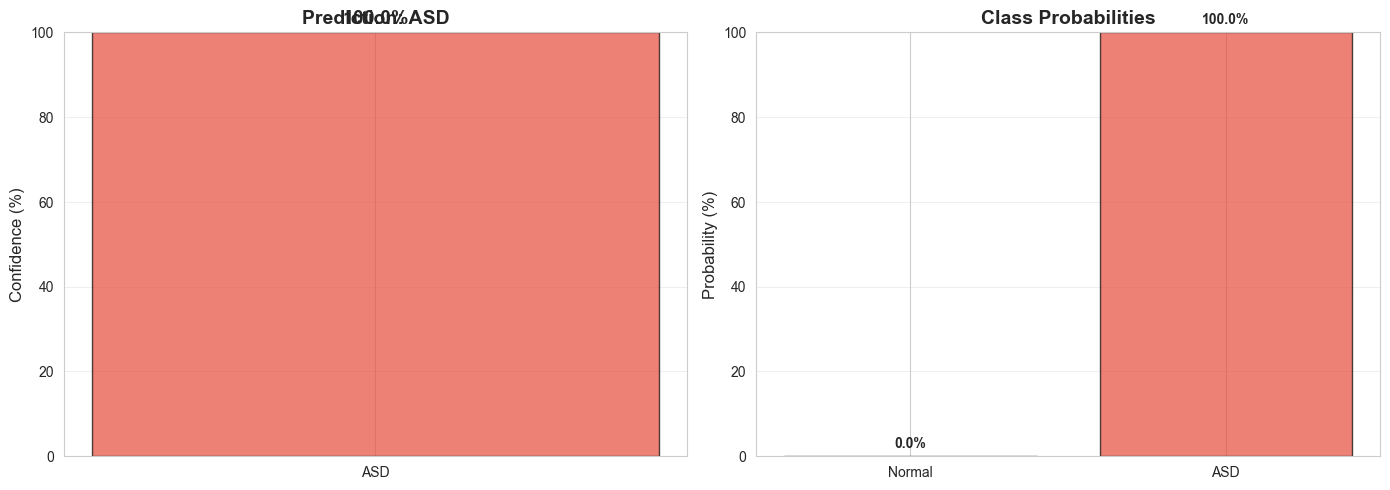

In [15]:
# Example: Predict for a subject from test set
# Using the first ASD subject as an example
example_file = os.path.join(asd_path, 'ASD Subject 01.csv')

print(f"Testing prediction on: {os.path.basename(example_file)}")
result = predict_asd(example_file)

## Summary and Clinical Implications

### Key Findings:
1. **Model Performance**: Multiple ML algorithms achieved high accuracy in distinguishing ASD from neurotypical subjects
2. **Best Model**: The model with highest test accuracy provides reliable predictions for clinical screening
3. **Feature Importance**: Specific brain connectivity patterns are strong indicators of ASD

### Clinical Significance:
- **Early Detection**: Enables identification of ASD in infants/toddlers before behavioral symptoms fully manifest
- **Timely Intervention**: Early diagnosis allows for therapeutic interventions during critical developmental windows
- **Objective Assessment**: fMRI-based prediction provides objective biomarkers complementing behavioral assessments
- **Improved Outcomes**: Early intervention significantly improves developmental trajectories and quality of life

### Next Steps:
1. Validate models on larger, diverse datasets
2. Integrate with clinical metadata (age, gender, family history)
3. Develop explainable AI methods for clinical interpretability
4. Create user-friendly interface for clinical deployment
5. Conduct prospective clinical trials

### Limitations:
- Dataset size may limit generalization
- fMRI scanning requires specialized equipment and expertise
- Need for longitudinal validation studies
- Ethical considerations for infant/toddler scanning

### Conclusion:
This predictive model demonstrates the potential of machine learning and fMRI data for early ASD detection, offering a promising tool for clinical screening and early intervention strategies.